## Environment Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
%cd rapidsai-csp-utils
!git checkout 22.12-patch
%cd ..
!python rapidsai-csp-utils/colab/env-check.py
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 390 (delta 89), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (390/390), 107.11 KiB | 333.00 KiB/s, done.
Resolving deltas: 100% (191/191), done.
/content/rapidsai-csp-utils
Branch '22.12-patch' set up to track remote branch '22.12-patch' from 'origin'.
Switched to a new branch '22.12-patch'
/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.5 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/env-check.py", line 26, in <module>
    gpu_name = pynvml.nvmlDeviceGetName(pynvml.nvmlDeviceGetHandleByIndex(0)).decode('UTF-8')
AttributeError: 'str' object has no attribute 'decode'. Did you mean: 'encode'?
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/pip-install.py", line 26, in <module>
    gpu_name

In [3]:
# Install the Merlin Framework
!pip install -U git+https://github.com/NVIDIA-Merlin/models.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/nvtabular.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/core.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/system.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/dataloader.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/Transformers4Rec.git@release-23.04
!pip install -U xgboost lightfm implicit

  Cloning https://github.com/NVIDIA-Merlin/models.git (to revision release-23.04) to /tmp/pip-req-build-a98nwt_x
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA-Merlin/models.git /tmp/pip-req-build-a98nwt_x
  Running command git checkout -b release-23.04 --track origin/release-23.04
  Switched to a new branch 'release-23.04'
  Branch 'release-23.04' set up to track remote branch 'release-23.04' from 'origin'.
  Resolved https://github.com/NVIDIA-Merlin/models.git to commit 56c7d6a4b2ec003472bdd176e972125632d070de
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 5.6 MB/s eta 0:00:00
  Installing buil

## Prepare the Dataset
Reference
- https://github.com/NVIDIA-Merlin/Merlin/blob/main/examples/getting-started-movielens/01-Download-Convert.ipynb


In [ ]:
import os

from merlin.core.utils import download_file

# Get dataframe library - cudf or pandas
from merlin.core.dispatch import get_lib
pd = get_lib()
import numpy as np

In [ ]:
DATA_DIR = os.environ.get(
    "DATA_DIR", os.path.expanduser("/content/drive/MyDrive/ml-twotower-model/data/")
)

In [ ]:
data_path = os.path.join(DATA_DIR, "ml-100k")
if not os.path.isdir(data_path):
    download_file(
        "http://files.grouplens.org/datasets/movielens/ml-100k.zip",
        os.path.join(DATA_DIR, "ml-100k.zip"),
    )

In [ ]:
data_path = DATA_DIR + 'ml-100k/'

# Load user ratings data
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings_data = pd.read_csv(data_path + 'u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# Load movie information data
movies_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'action',
               'adventure', 'animation', 'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy',
               'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western']
movies_data = pd.read_csv(data_path + 'u.item', sep='|', names=movies_cols, encoding='latin-1')

# Load user information data
users_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users_data = pd.read_csv(data_path + 'u.user', sep='|', names=users_cols, encoding='latin-1')

# Step 3: Merge DataFrames
# Merge user ratings with movie information
merged_data = pd.merge(ratings_data, movies_data, on='movie_id')

# Merge the above DataFrame with user information
merged_data = pd.merge(merged_data, users_data, on='user_id')

# Combine the individual genre columns into a single categorical column
genre_cols = ['action', 'adventure', 'animation', 'children', 'comedy', 'crime', 'documentary', 'drama',
              'fantasy', 'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western']

# Create a new column 'genres' by concatenating the genre names if the value is 1
merged_data['genres'] = merged_data[genre_cols].apply(lambda row: '|'.join([col for col in genre_cols if row[col] == 1]), axis=1)

# Drop the individual genre columns + `unknown` + `video_release_date` + `imdb_url`
merged_data.drop(columns=genre_cols + ['unknown', 'video_release_date', 'imdb_url'], inplace=True)

# convert genres to a list
merged_data["genres"] = merged_data["genres"].str.split("|")

# Step 4: Save as parquet
merged_data.to_parquet(f'{DATA_DIR}/movielens_100k.parquet', index=False)

print("Conversion to parquet completed successfully.")

Conversion to parquet completed successfully.


In [ ]:
merged_data

,user_id,movie_id,rating,timestamp,title,release_date,age,gender,occupation,zip_code,genres
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,49,M,writer,55105,[comedy]
1,196,257,2,881251577,Men in Black (1997),04-Jul-1997,49,M,writer,55105,"[action, adventure, comedy, sci_fi]"
2,196,111,4,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,49,M,writer,55105,"[comedy, romance]"
3,196,25,4,881251955,"Birdcage, The (1996)",08-Mar-1996,49,M,writer,55105,[comedy]
4,196,382,4,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,49,M,writer,55105,"[comedy, drama]"
...,...,...,...,...,...,...,...,...,...,...,...
99995,873,313,5,891392177,Titanic (1997),01-Jan-1997,48,F,administrator,33763,"[action, drama, romance]"
99996,873,326,4,891392656,G.I. Jane (1997),01-Jan-1997,48,F,administrator,33763,"[action, drama, war]"
99997,873,348,3,891392577,Desperate Measures (1998),30-Jan-1998,48,F,administrator,33763,"[crime, drama, thriller]"
99998,873,358,2,891392698,Spawn (1997),01-Aug-1997,48,F,administrator,33763,"[action, adventure, sci_fi, thriller]"


## ETL
Reference
- https://github.com/NVIDIA-Merlin/Merlin/blob/main/examples/getting-started-movielens/02-ETL-with-NVTabular.ipynb

In [1]:
import os
import shutil
import numpy as np
from nvtabular import ops
from merlin.schema.tags import Tags

import nvtabular as nvt

from os import path

# Get dataframe library - cudf or pandas
from merlin.core.dispatch import get_lib
pd = get_lib()

/usr/local/lib/python3.10/dist-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


In [2]:
DATA_DIR = os.environ.get(
    "DATA_DIR", os.path.expanduser("/content/drive/MyDrive/ml-twotower-model/data/")
)

In [3]:
movies = pd.read_parquet(os.path.join(DATA_DIR, "movielens_100k.parquet"))
movies.head()

,user_id,movie_id,rating,timestamp,title,release_date,age,gender,occupation,zip_code,genres
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,49,M,writer,55105,[comedy]
1,196,257,2,881251577,Men in Black (1997),04-Jul-1997,49,M,writer,55105,"[action, adventure, comedy, sci_fi]"
2,196,111,4,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,49,M,writer,55105,"[comedy, romance]"
3,196,25,4,881251955,"Birdcage, The (1996)",08-Mar-1996,49,M,writer,55105,[comedy]
4,196,382,4,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,49,M,writer,55105,"[comedy, drama]"


### Clean title and movie_id relattionship

In [4]:
movies['movie_id'].nunique(), movies['title'].nunique()

(1682, 1664)

In [5]:
title_movie_id_index = movies[['movie_id', 'title']].groupby(['movie_id', 'title'], as_index=False).count()
title_movie_id_index.head()

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
faulty_movie_id_title =  title_movie_id_index[title_movie_id_index.duplicated('title')]
faulty_movie_id_title_map =  {key: value for key, value in zip(faulty_movie_id_title['title'], faulty_movie_id_title['movie_id'])}
faulty_movie_id_title_map

{'Chasing Amy (1997)': 268,
 "Ulee's Gold (1997)": 303,
 'Desperate Measures (1998)': 348,
 'Fly Away Home (1996)': 500,
 'Body Snatchers (1993)': 670,
 'Kull the Conqueror (1997)': 680,
 'Ice Storm, The (1997)': 865,
 'Money Talks (1997)': 881,
 'That Darn Cat! (1997)': 1003,
 'Designated Mourner, The (1997)': 1257,
 'Deceiver (1997)': 1606,
 'Hurricane Streets (1998)': 1607,
 'Hugo Pool (1997)': 1617,
 'Nightwatch (1997)': 1625,
 'Butcher Boy, The (1998)': 1650,
 'Chairman of the Board (1998)': 1654,
 'Substance of Fire, The (1996)': 1658,
 'Sliding Doors (1998)': 1680}

In [7]:
for title, movie_id in faulty_movie_id_title_map.items():
    movies.loc[movies['title'] == title, 'movie_id'] = movie_id

In [8]:
#sanity check
assert movies['movie_id'].nunique() == movies['title'].nunique()
movies.head()

,user_id,movie_id,rating,timestamp,title,release_date,age,gender,occupation,zip_code,genres
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,49,M,writer,55105,[comedy]
1,196,257,2,881251577,Men in Black (1997),04-Jul-1997,49,M,writer,55105,"[action, adventure, comedy, sci_fi]"
2,196,111,4,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,49,M,writer,55105,"[comedy, romance]"
3,196,25,4,881251955,"Birdcage, The (1996)",08-Mar-1996,49,M,writer,55105,[comedy]
4,196,382,4,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,49,M,writer,55105,"[comedy, drama]"


### Create Genre and movie_id mapping

In [9]:
genres = movies[['movie_id','genres']]
def merge_list(srs):
    return list(set(item for sublist in srs for item in sublist))
genres = genres.groupby('movie_id')['genres'].agg(merge_list).reset_index()
genres

,movie_id,genres
0,1,"[comedy, children, animation]"
1,2,"[action, thriller, adventure]"
2,3,[thriller]
3,4,"[action, drama, comedy]"
4,5,"[thriller, crime, drama]"
...,...,...
1659,1678,[drama]
1660,1679,"[thriller, romance]"
1661,1680,"[drama, romance]"
1662,1681,[comedy]


### Prepare baseline Dataset

In [10]:
# split train, val, test - 80,10,10
sorted_movies = movies.sort_values(by="timestamp")
test_size = int(len(movies) * 0.1)

# selective columns
cols = ['user_id', 'movie_id', 'rating', 'gender', 'occupation',] #title]
sorted_movies = sorted_movies[cols]

train = sorted_movies[:-test_size * 2].sample(frac=1).reset_index(drop=True)
val = sorted_movies[-test_size * 2: -test_size].sample(frac=1).reset_index(drop=True)
test = sorted_movies[-test_size: ].sample(frac=1).reset_index(drop=True)


In [11]:
train = pd.merge(train, genres, on='movie_id')
val = pd.merge(val, genres, on='movie_id')
test = pd.merge(test, genres, on='movie_id')

In [12]:
train.to_parquet(os.path.join(DATA_DIR, "train.parquet"))
val.to_parquet(os.path.join(DATA_DIR, "validation.parquet"))
test.to_parquet(os.path.join(DATA_DIR, "test.parquet"))

In [13]:
USER_FEATURE_COLUMNS = ["gender", "occupation"]
ITEM_FEATURE_GENRES = ['genres']
LABEL_COLUMNS = ["rating"]

In [14]:
userId = ["user_id"]
movieId = ["movie_id"]

CATEGORICAL_COLUMNS = USER_FEATURE_COLUMNS + userId + movieId

In [15]:
# we will add Categorify for our categorical features
cat_features =  CATEGORICAL_COLUMNS >> ops.Categorify()

In [16]:
feats_itemId = cat_features["movie_id"] >> ops.TagAsItemID()
# used for merging augmented data
fearts_itemId_raw = ['movie_id'] >> ops.Rename(postfix='_raw') >> ops.LambdaOp(lambda col: col.astype("int32"))
feats_userId = cat_features["user_id"] >> ops.TagAsUserID()
feats_user = cat_features[USER_FEATURE_COLUMNS] >> ops.TagAsUserFeatures()
feats_item_genres = ITEM_FEATURE_GENRES >> ops.Categorify() >> ops.TagAsItemFeatures()
feats_target = (
    nvt.ColumnSelector(LABEL_COLUMNS)
    >> ops.LambdaOp(lambda col: (col > 3).astype("int32"))
    >> ops.AddTags(["binary_classification", "target"])
)
output = feats_itemId + feats_userId + feats_user + feats_item_genres + feats_target + fearts_itemId_raw

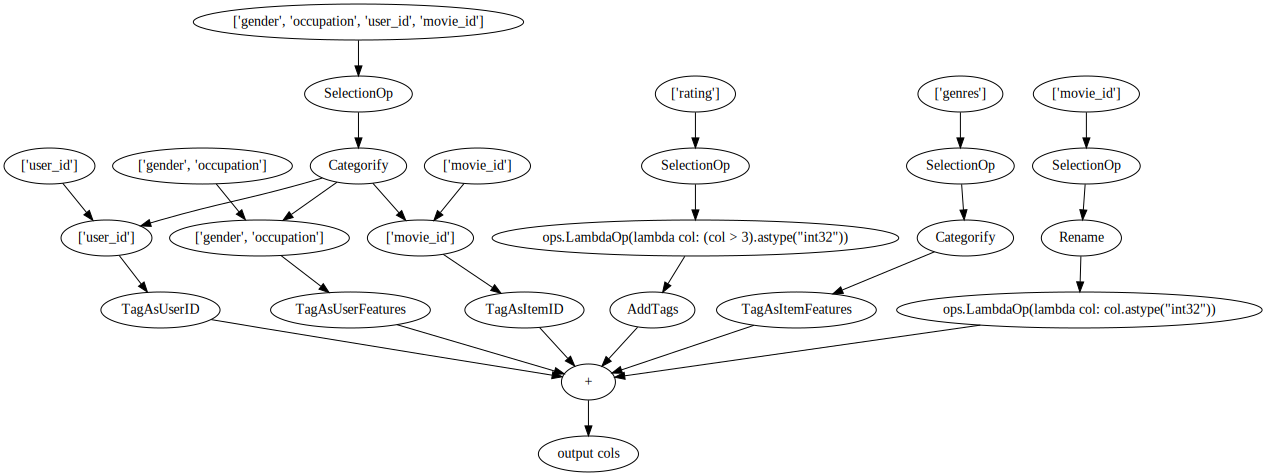

In [17]:
output.graph

In [18]:
workflow = nvt.Workflow(output)

In [19]:
dict_dtypes = {}

for col in CATEGORICAL_COLUMNS:
    dict_dtypes[col] = np.int64

for col in LABEL_COLUMNS:
    dict_dtypes[col] = np.float32

In [20]:
train_dataset = nvt.Dataset([os.path.join(DATA_DIR, "train.parquet")])
val_dataset = nvt.Dataset([os.path.join(DATA_DIR, "validation.parquet")])
test_dataset = nvt.Dataset([os.path.join(DATA_DIR, "test.parquet")])

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [21]:
%%time
workflow.fit(train_dataset)

/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tag

CPU times: user 1.82 s, sys: 86.1 ms, total: 1.9 s
Wall time: 3.63 s


/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed i

In [22]:
dict_dtypes

{'gender': numpy.int64,
 'occupation': numpy.int64,
 'user_id': numpy.int64,
 'movie_id': numpy.int64,
 'rating': numpy.float32}

In [23]:
%%time
train_dataset_trans =  workflow.transform(train_dataset)
train_dataset_trans.to_parquet(
    output_path=os.path.join(DATA_DIR, "train"),
    shuffle=nvt.io.Shuffle.PER_PARTITION,
    cats=CATEGORICAL_COLUMNS,
    labels=LABEL_COLUMNS,
    dtypes=dict_dtypes
)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(


CPU times: user 1.35 s, sys: 48.8 ms, total: 1.4 s
Wall time: 1.54 s


In [24]:
%%time
val_dataset_trans =  workflow.transform(val_dataset)
val_dataset_trans.to_parquet(
    output_path=os.path.join(DATA_DIR, "valid"),
    shuffle=False,
    cats=CATEGORICAL_COLUMNS,
    labels=LABEL_COLUMNS,
    dtypes=dict_dtypes,
)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(


CPU times: user 304 ms, sys: 7.84 ms, total: 312 ms
Wall time: 347 ms


In [25]:
%%time
workflow.transform(test_dataset).to_parquet(
    output_path=os.path.join(DATA_DIR, "test"),
    shuffle=False,
    cats=CATEGORICAL_COLUMNS,
    labels=LABEL_COLUMNS,
    dtypes=dict_dtypes,
)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(


CPU times: user 300 ms, sys: 1.37 ms, total: 301 ms
Wall time: 339 ms


In [26]:
workflow.save(os.path.join(DATA_DIR, "workflow"))
workflow.output_schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.start_index,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.value_count.min,properties.value_count.max
0,movie_id,"(Tags.CATEGORICAL, Tags.ITEM_ID, Tags.ITEM, Ta...","DType(name='int64', element_type=<ElementType....",False,False,NaN,0.0,0.0,0.0,.//categories/unique.movie_id.parquet,0.0,1603.0,movie_id,1604.0,100.0,NaN,NaN
1,user_id,"(Tags.CATEGORICAL, Tags.USER_ID, Tags.USER, Ta...","DType(name='int64', element_type=<ElementType....",False,False,NaN,0.0,0.0,0.0,.//categories/unique.user_id.parquet,0.0,751.0,user_id,752.0,65.0,NaN,NaN
2,gender,"(Tags.CATEGORICAL, Tags.USER)","DType(name='int64', element_type=<ElementType....",False,False,NaN,0.0,0.0,0.0,.//categories/unique.gender.parquet,0.0,2.0,gender,3.0,16.0,NaN,NaN
3,occupation,"(Tags.CATEGORICAL, Tags.USER)","DType(name='int64', element_type=<ElementType....",False,False,NaN,0.0,0.0,0.0,.//categories/unique.occupation.parquet,0.0,21.0,occupation,22.0,16.0,NaN,NaN
4,genres,"(Tags.CATEGORICAL, Tags.ITEM)","DType(name='int64', element_type=<ElementType....",True,True,NaN,0.0,0.0,0.0,.//categories/unique.genres.parquet,0.0,19.0,genres,20.0,16.0,0.0,NaN
5,rating,"(Tags.BINARY_CLASSIFICATION, Tags.TARGET)","DType(name='int32', element_type=<ElementType....",False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,movie_id_raw,(),"DType(name='int32', element_type=<ElementType....",False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# check that movie_id_raw is intact
assert (train_dataset_trans.to_ddf().compute()['movie_id_raw'] == train_dataset.to_ddf().compute()['movie_id']).all()

In [28]:
train_dataset_trans.to_ddf().head()

,movie_id,user_id,gender,occupation,genres,rating,movie_id_raw
0,811,312,1,1,[2],0,734
1,811,23,1,1,[2],0,734
2,811,52,2,1,[2],0,734
3,811,7,1,1,[2],0,734
4,811,86,2,2,[2],0,734


#### Sanity Check

In [29]:
import glob

TRAIN_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, "train", "*.parquet")))
VALID_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, "valid", "*.parquet")))
TEST_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, "test", "*.parquet")))
TRAIN_PATHS, VALID_PATHS, TEST_PATHS

(['/content/drive/MyDrive/ml-twotower-model/data/train/part_0.parquet'],
 ['/content/drive/MyDrive/ml-twotower-model/data/valid/part_0.parquet'],
 ['/content/drive/MyDrive/ml-twotower-model/data/test/part_0.parquet'])

In [30]:
df = pd.read_parquet(TRAIN_PATHS[0])
df

,movie_id,user_id,gender,occupation,genres,rating,movie_id_raw
0,407,533,1,13,[1],1.0,52
1,283,119,1,3,"[4, 2, 14]",1.0,408
2,97,282,1,3,[1],1.0,215
3,585,108,1,8,[2],1.0,516
4,1206,385,2,1,[5],0.0,1394
...,...,...,...,...,...,...,...
79995,1325,1,2,10,[1],0.0,1260
79996,23,149,1,2,"[3, 4]",1.0,79
79997,874,1,2,10,[11],0.0,816
79998,722,98,1,9,[2],1.0,1059


In [31]:
df = pd.read_parquet(VALID_PATHS[0])
df

,movie_id,user_id,gender,occupation,genres,rating,movie_id_raw
0,89,661,1,3,[13],1.0,143
1,89,0,1,11,[13],0.0,143
2,89,0,2,7,[13],1.0,143
3,89,0,1,18,[13],1.0,143
4,89,0,1,15,[13],0.0,143
...,...,...,...,...,...,...,...
9995,736,0,1,11,[2],0.0,368
9996,862,0,1,7,[1],0.0,933
9997,786,750,1,2,"[1, 10, 6]",0.0,457
9998,611,0,2,11,"[1, 2]",0.0,1197


In [32]:
df = pd.read_parquet(TEST_PATHS[0])
df

,movie_id,user_id,gender,occupation,genres,rating,movie_id_raw
0,390,0,1,13,[11],0.0,448
1,390,0,1,1,[11],1.0,448
2,390,0,2,11,[11],0.0,448
3,390,0,2,7,[11],1.0,448
4,390,0,2,6,[11],0.0,448
...,...,...,...,...,...,...,...
9995,1105,0,1,3,[18],1.0,954
9996,1314,0,2,14,[1],0.0,994
9997,913,0,1,5,"[2, 17, 7, 10, 6, 5]",0.0,560
9998,1120,0,1,6,"[3, 4, 6]",0.0,1314


### Augment Data

In [33]:
! pip install transformers

In [34]:
import merlin.io

In [50]:
# load dataset with synopsis
synopsis_df = pd.read_parquet(os.path.join(DATA_DIR, 'movielens_100k_synopsis_raw.parquet'))
synopsis_df

,movie_id,title,synopsis,cast
0,242,Kolya (1996),Kolya (1996) is a Czech comedy-drama film dire...,"Zdeněk Svěrák, Andrej Chal"
1,257,Men in Black (1997),"In Men in Black, Will Smith plays a talented N...","Will Smith, Tommy Lee Jones, Linda Fiorentino,..."
2,111,"Truth About Cats & Dogs, The (1996)","""The Truth About Cats & Dogs"" is a romantic co...","Uma Thurman, Janeane Garofalo, Ben Chaplin"
3,25,"Birdcage, The (1996)","In ""Birdcage, The"", a gay cabaret owner and hi...","Robin Williams, Nathan Lane, Gene Hackman, Dia..."
4,382,"Adventures of Priscilla, Queen of the Desert, ...","""Adventures of Priscilla, Queen of the Desert""...","Terence Stamp, Hugo Weaving, Guy Pearce"
...,...,...,...,...
1677,1310,"Walk in the Sun, A (1945)","""A Walk in the Sun"" is a 1945 war drama film t...","Dana Andrews, Richard Conte, George Tyne, John..."
1678,1614,"Reluctant Debutante, The (1958)",The Reluctant Debutante (1958) tells the story...,"Rex Harrison, Kay Kendall, John Saxon, Sandra"
1679,1505,Killer: A Journal of Murder (1995),"""Killer: A Journal of Murder"" is a 1995 crime ...","James Woods, Robert Sean Leonard, Ellen Greene..."
1680,1533,I Don't Want to Talk About It (De eso no se ha...,"""I Don't Want to Talk About It"" (De eso no se ...","Marcello Mastroianni, Luisina Brando, Alejandr..."


In [51]:
# fix synopsis_df, correctly map title and movie_id
for title, movie_id in faulty_movie_id_title_map.items():
    synopsis_df.loc[synopsis_df['title'] == title, 'movie_id'] = movie_id
synopsis_df.drop_duplicates(inplace=True)

In [52]:
synopsis_df.shape

(1664, 4)

In [53]:
assert synopsis_df['title'].nunique() == synopsis_df['movie_id'].nunique()

In [54]:
# Transform cast into list
synopsis_df['cast'] = synopsis_df['cast'].apply(str.lower).str.split(',')
synopsis_df.head()

,movie_id,title,synopsis,cast
0,242,Kolya (1996),Kolya (1996) is a Czech comedy-drama film dire...,"[zdeněk svěrák, andrej chal]"
1,257,Men in Black (1997),"In Men in Black, Will Smith plays a talented N...","[will smith, tommy lee jones, linda fiorenti..."
2,111,"Truth About Cats & Dogs, The (1996)","""The Truth About Cats & Dogs"" is a romantic co...","[uma thurman, janeane garofalo, ben chaplin]"
3,25,"Birdcage, The (1996)","In ""Birdcage, The"", a gay cabaret owner and hi...","[robin williams, nathan lane, gene hackman, ..."
4,382,"Adventures of Priscilla, Queen of the Desert, ...","""Adventures of Priscilla, Queen of the Desert""...","[terence stamp, hugo weaving, guy pearce]"


#### Generate Custom Embeddings

In [55]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
# from transformers import DistilBertTokenizer, TFDistilBertModel

# from tensorflow.keras import mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

# use this if there is CUDA OOM
# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
# bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [56]:
from tqdm import tqdm
def get_bert_embeddings_pooled(input, tokenizer, model, batch_size):
    # Tokenize the list of strings
    tokenized_inputs = tokenizer(input, padding=True, truncation=True, return_tensors="tf")

    # Get the number of samples in the dataset
    num_samples = len(tokenized_inputs["input_ids"])

    # Create a dataset from the tokenized inputs
    dataset = tf.data.Dataset.from_tensor_slices(tokenized_inputs)

    # Batch the dataset
    batched_dataset = dataset.batch(batch_size)

    # Initialize a list to store the embeddings
    embeddings = []

    # Pass the batched inputs through the BERT model to get the embeddings
    with tf.device('/GPU:0'):  # Use GPU if available for faster inference
        for batch in tqdm(batched_dataset):
            batch_embeddings = model(**batch)[0]
            pooled = tf.reduce_mean(batch_embeddings, axis=1)
            embeddings.append(pooled)

    # Concatenate the embeddings from different batches
    embeddings = tf.concat(embeddings, axis=0)

    return embeddings

In [57]:
batch_size = 64
synopsis_embeddings = get_bert_embeddings_pooled(synopsis_df['synopsis'].tolist(), tokenizer, bert_model, batch_size)

100%|██████████| 26/26 [00:20<00:00,  1.27it/s]


In [58]:
batch_size = 64
title_embeddings = get_bert_embeddings_pooled(synopsis_df['title'].tolist(), tokenizer, bert_model, batch_size)

100%|██████████| 26/26 [00:10<00:00,  2.54it/s]


In [59]:
synopsis_embeddings.shape, title_embeddings.shape

(TensorShape([1664, 768]), TensorShape([1664, 768]))

#### Save Embeddings

In [67]:
embeddings_df = pd.DataFrame({
    'movie_id_raw': synopsis_df['movie_id'].tolist(),
    'title': title_embeddings.numpy().tolist(),
    'synopsis': synopsis_embeddings.numpy().tolist(),
})
embeddings_df

,movie_id_raw,title,synopsis
0,242,"[-0.13162778317928314, -0.10936661064624786, -...","[-0.22289082407951355, 0.27888065576553345, 0...."
1,257,"[0.08139041066169739, -0.16367477178573608, -0...","[-0.11132552474737167, -0.04103025048971176, 0..."
2,111,"[0.15842819213867188, -0.032023221254348755, -...","[0.07356611639261246, -0.005173327401280403, 0..."
3,25,"[-0.13973252475261688, -0.19878588616847992, -...","[0.07982735335826874, -0.12655968964099884, 0...."
4,382,"[-0.18689653277397156, -0.19982194900512695, 0...","[0.06059129536151886, 0.12666839361190796, 0.2..."
...,...,...,...
1659,1310,"[-0.2265368103981018, -0.2588498294353485, -0....","[-0.08413532376289368, 0.08119747787714005, 0...."
1660,1614,"[-0.26486313343048096, -0.38513806462287903, -...","[-0.23628373444080353, 0.03729664906859398, 0...."
1661,1505,"[-0.07384374737739563, -0.405456006526947, -0....","[-0.18576298654079437, 0.12107933312654495, 0...."
1662,1533,"[0.11791486293077469, -0.1459496170282364, -0....","[0.026467198505997658, 0.007153607439249754, 0..."


In [70]:
# merge with train_dataset
train_dataset_trans_df = train_dataset_trans.to_ddf().compute()
train_dataset_trans_df

,movie_id,user_id,gender,occupation,genres,rating,movie_id_raw
0,811,312,1,1,[2],0,734
1,811,23,1,1,[2],0,734
2,811,52,2,1,[2],0,734
3,811,7,1,1,[2],0,734
4,811,86,2,2,[2],0,734
...,...,...,...,...,...,...,...
79995,1555,107,1,5,[1],1,1189
79996,1492,43,1,4,"[1, 2]",0,1626
79997,1481,1,2,10,[1],0,1584
79998,1476,1,2,10,[1],0,1590


In [89]:
movie_id_trans =  train_dataset_trans_df[['movie_id_raw', 'movie_id']].groupby(['movie_id_raw', 'movie_id'], as_index=False).count()
movie_id_trans

,movie_id_raw,movie_id
0,1,7
1,2,231
2,3,337
3,4,99
4,5,366
...,...,...
1598,1676,1514
1599,1677,1517
1600,1680,1310
1601,1681,1502


In [92]:
only_train_embeddings = pd.merge(embeddings_df, movie_id_trans, how='inner', on='movie_id_raw')
only_train_embeddings

,movie_id_raw,title,synopsis,movie_id
0,242,"[-0.13162778317928314, -0.10936661064624786, -...","[-0.22289082407951355, 0.27888065576553345, 0....",279
1,257,"[0.08139041066169739, -0.16367477178573608, -0...","[-0.11132552474737167, -0.04103025048971176, 0...",31
2,111,"[0.15842819213867188, -0.032023221254348755, -...","[0.07356611639261246, -0.005173327401280403, 0...",41
3,25,"[-0.13973252475261688, -0.19878588616847992, -...","[0.07982735335826874, -0.12655968964099884, 0....",30
4,382,"[-0.18689653277397156, -0.19982194900512695, 0...","[0.06059129536151886, 0.12666839361190796, 0.2...",303
...,...,...,...,...
1598,1657,"[-0.06935157626867294, -0.3555041551589966, -0...","[-0.04539063572883606, 0.08155060559511185, 0....",1494
1599,1515,"[-0.10045406222343445, -0.2019217312335968, -0...","[-0.1678621768951416, 0.07765717059373856, 0.0...",1600
1600,1614,"[-0.26486313343048096, -0.38513806462287903, -...","[-0.23628373444080353, 0.03729664906859398, 0....",1516
1601,1505,"[-0.07384374737739563, -0.405456006526947, -0....","[-0.18576298654079437, 0.12107933312654495, 0....",1597


In [95]:
only_train_embeddings.drop('movie_id_raw', axis=1).to_parquet(os.path.join(DATA_DIR, 'embeddings_index_v2.parquet'), index=False)

#### Transform

In [ ]:
# # merge the dataframe with original dataframe
# aug_df = pd.merge(movies, synopsis_df.drop('title', axis=1), on='movie_id')
# aug_df

In [ ]:
# index are required to replce string with embeddings
synopsis_index, title_index = {}, {}
synopsis_ls = synopsis_df['synopsis'].tolist()
title_ls = synopsis_df['title'].tolist()
for i in range(len(synopsis_ls)):
    synopsis_index[synopsis_ls[i]] = i
    title_index[title_ls[i]] = i


In [ ]:
from functools import cache
def title_index_lambdaop(col):
    @cache
    def _get_title_embedding(input):
        # print(title_embeddings[title_index[input]].shape)
        return title_embeddings[title_index[input]].numpy().astype("float32")
    _col = col.apply(_get_title_embedding)
    return _col

def synopsis_index_lambdaop(col):
    @cache
    def _get_synopsis_embedding(input):
        return synopsis_embeddings[synopsis_index[input]].numpy().astype("float32")
    _col = col.apply(_get_synopsis_embedding)
    return _col

In [ ]:
# def custom_embedding(col_name):
#     def custom_func(df):
#         return df[col_name].map(custom_embeddings_map[col_name])

#     return custom_func

In [ ]:
# # create operations for augmented columns
# embedding_feats = ['synopsis', 'title']
# feats_item_embedding = None
# for col in embedding_feats:
#     custom_embedding_op = ops.LambdaOp(custom_embedding(col))
#     feats_item_embedding = (feats_item_embedding + custom_embedding_op) if feats_item_embedding else custom_embedding_op
# # feats_item_embedding = embedding_feats >> ops.LambdaOp(lambda col: custom_embedding(col)()) >> ops.TagAsItemFeatures

In [4]:
# taken from previous cell
feats_itemId = cat_features["movie_id"] >> ops.TagAsItemID()
# used for merging augmented data
# fearts_itemId_raw = ['movie_id'] >> ops.Rename(postfix='_raw') >> ops.LambdaOp(lambda col: col.astype("int32"))
feats_userId = cat_features["user_id"] >> ops.TagAsUserID()
feats_item = cat_features[ITEM_FEATURE_COLUMNS] >> ops.TagAsItemFeatures()
feats_item_genres = ITEM_FEATURE_GENRES >> ops.Categorify() >> ops.TagAsItemFeatures()
feats_target = (
    nvt.ColumnSelector(LABEL_COLUMNS)
    >> ops.LambdaOp(lambda col: (col > 3).astype("int32"))
    >> ops.AddTags(["binary_classification", "target"])
)
output = feats_itemId + feats_userId + feats_item + feats_item_genres + feats_target

NameError: ignored

In [ ]:
feats_item_synopsis = ['synopsis'] >> ops.LambdaOp(synopsis_index_lambdaop) >> ops.TagAsItemFeatures() >> ops.AddTags(Tags.CATEGORICAL)
feats_item_title = ['title'] >> ops.LambdaOp(title_index_lambdaop) >> ops.TagAsItemFeatures() >> ops.AddTags(Tags.CATEGORICAL)
feats_item_cast = ['cast'] >> ops.Categorify() >> ops.TagAsItemFeatures()
fearts_itemId_raw = ['movie_id'] >> ops.Rename(postfix='_raw') >> ops.LambdaOp(lambda col: col.astype("int32"))

# output is previous workflow
aug_output = output + feats_item_synopsis + feats_item_title + feats_item_cast #+ fearts_itemId_raw

In [ ]:
# feats_item_synopsis = ['synopsis'] >> ops.AddTags(Tags.CATEGORICAL) >> ops.TagAsItemFeatures()
# feats_item_title = ['title'] >> ops.AddTags(Tags.CATEGORICAL) >> ops.TagAsItemFeatures()
# feats_item_cast = ['cast'] >> ops.Categorify() >> ops.TagAsItemFeatures()
# fearts_itemId_raw = ['movie_id'] >> ops.Rename(postfix='_raw') >> ops.LambdaOp(lambda col: col.astype("int32"))


# aug_output = feats_item_synopsis + feats_item_title + feats_item_cast +fearts_itemId_raw

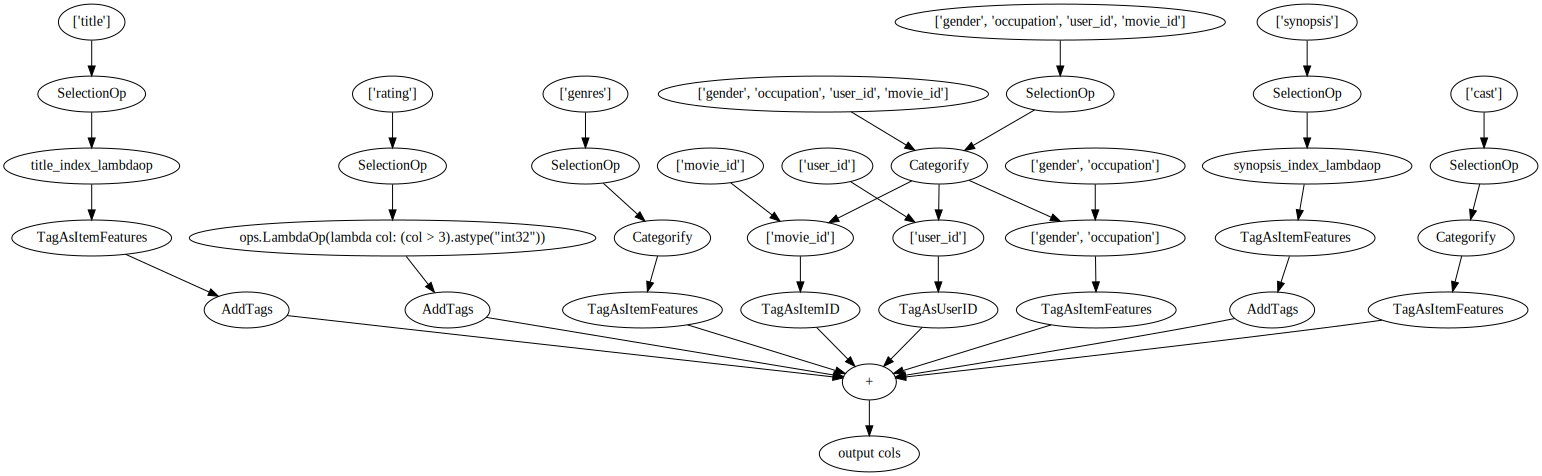

In [ ]:
aug_output.graph

In [ ]:
synopsis_dataset = merlin.io.dataset.Dataset(synopsis_df)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [ ]:
# merge with train, val and test
train_dataset_aug = merlin.io.dataset.Dataset.merge(train_dataset, synopsis_dataset, on='movie_id')
val_dataset_aug = merlin.io.dataset.Dataset.merge(val_dataset, synopsis_dataset, on='movie_id')
test_dataset_aug = merlin.io.dataset.Dataset.merge(test_dataset, synopsis_dataset, on='movie_id')

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [ ]:
train_dataset_aug.to_ddf().compute()

,user_id,movie_id,rating,gender,occupation,genres,title,synopsis,cast
0,764,237,4,F,educator,"[romance, drama]",Jerry Maguire (1996),Jerry Maguire is a sports agent who suddenly h...,"[tom cruise, renée zellweger, cuba gooding j..."
1,894,237,4,M,educator,"[romance, drama]",Jerry Maguire (1996),Jerry Maguire is a sports agent who suddenly h...,"[tom cruise, renée zellweger, cuba gooding j..."
2,186,237,2,F,executive,"[romance, drama]",Jerry Maguire (1996),Jerry Maguire is a sports agent who suddenly h...,"[tom cruise, renée zellweger, cuba gooding j..."
3,497,237,3,M,student,"[romance, drama]",Jerry Maguire (1996),Jerry Maguire is a sports agent who suddenly h...,"[tom cruise, renée zellweger, cuba gooding j..."
4,318,237,5,M,retired,"[romance, drama]",Jerry Maguire (1996),Jerry Maguire is a sports agent who suddenly h...,"[tom cruise, renée zellweger, cuba gooding j..."
...,...,...,...,...,...,...,...,...,...
79995,405,1582,1,F,healthcare,[film_noir],T-Men (1947),T-Men is a 1947 film noir crime thriller. The ...,"[dennis o'keefe, mary meade, charles mcgraw,..."
79996,181,1390,1,M,executive,[crime],"Innocent Sleep, The (1995)","After a devastating car accident, a man wakes ...","[rupert graves, annabella sciorra, michael g..."
79997,181,1363,1,M,executive,[documentary],"Leopard Son, The (1996)",Leopard Son is a 1996 wildlife documentary tha...,"[derek jacobi, john bagge, debs paterson, t..."
79998,399,1543,3,M,other,[drama],Johns (1996),Johns (1996) is a drama film that follows the ...,"[david arquette, lukas haas, wilson cruz, k..."


In [ ]:
aug_workflow = nvt.Workflow(aug_output)

In [ ]:
%%time
train_dataset_aug_trans = aug_workflow.fit_transform(train_dataset_aug)

/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tag

CPU times: user 4.36 s, sys: 168 ms, total: 4.53 s
Wall time: 4.72 s


/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed i

In [ ]:
%%time
train_dataset_aug_trans.to_parquet(
    output_path=os.path.join(DATA_DIR, "train_aug"),
    shuffle=nvt.io.Shuffle.PER_PARTITION,
    cats=train_dataset_aug_trans.schema.select_by_tag(Tags.CATEGORICAL).column_names,
    labels=LABEL_COLUMNS,
    dtypes=dict_dtypes
)

/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(


CPU times: user 7.03 s, sys: 870 ms, total: 7.9 s
Wall time: 8.19 s


In [ ]:
%%time
aug_workflow.transform(val_dataset_aug).to_parquet(
    output_path=os.path.join(DATA_DIR, "valid_aug"),
    shuffle=False,
    cats=train_dataset_aug_trans.schema.select_by_tag(Tags.CATEGORICAL).column_names,
    labels=LABEL_COLUMNS,
    dtypes=dict_dtypes,
)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(


CPU times: user 2.09 s, sys: 180 ms, total: 2.27 s
Wall time: 2.27 s


In [ ]:
%%time
aug_workflow.transform(test_dataset_aug).to_parquet(
    output_path=os.path.join(DATA_DIR, "test_aug"),
    shuffle=False,
    cats=train_dataset_aug_trans.schema.select_by_tag(Tags.CATEGORICAL).column_names,
    labels=LABEL_COLUMNS,
    dtypes=dict_dtypes,
)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(


CPU times: user 3.17 s, sys: 202 ms, total: 3.37 s
Wall time: 4.26 s
